### Multimodal Hate Speech Classification and Cyberbullying Detection
#### This notebook implements a multimodal model combining image and text features for hate speech detection and cyberbullying classification.

##### Data Preprocessing

##### Load Annotations and Prepare Data

In [20]:
import json
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, LSTM, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
#Load the annotations
with open('./Datasets/MMHS150K_GT.json/MMHS150K_GT.json', 'r') as f:
    annotations = json.load(f)

In [22]:
data = []

for tweet_id, info in annotations.items():
    data.append({
        'tweet_id': tweet_id,
        'tweet_text': info  ['tweet_text'],
        'labels': info['labels'],
        'labels_str': info['labels_str']
    })
    
df = pd.DataFrame(data)

##### Add Image Path and Create Majority Label

In [23]:
# Path to the image folder
image__folder = '.\Datasets\img_resized'

In [24]:
# Add image path column
df['image_path'] = df['tweet_id'].apply(lambda x: os.path.join(image__folder, f"{x}.jpg"))

In [25]:
# Define majority vote function for labels
from collections import Counter

def majoriy_vote(labels):
    label_counts = Counter(labels)
    return label_counts.most_common(1)[0][0]


In [26]:
# Apply majority vote to create a single label column
df['majority_label'] = df['labels'].apply(majoriy_vote)


label_mapping = {
    0: "NotHate",
    1: "Racist",
    2: "Sexist",
    3: "Homophobe",
    4: "Religion",
    5: "OtherHate"
}

In [27]:
# Create a new column 'majority_label_str' with the string representation of the majority label
df['majority_label_str'] = df['majority_label'].map(label_mapping)

In [28]:
df.head()

,tweet_id,tweet_text,labels,labels_str,image_path,majority_label,majority_label_str
0,1114679353714016256,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]","[Religion, Racist, Homophobe]",.\Datasets\img_resized\1114679353714016256.jpg,4,Religion
1,1063020048816660480,My horses are retarded https://t.co/HYhqc6d5WN,"[5, 5, 5]","[OtherHate, OtherHate, OtherHate]",.\Datasets\img_resized\1063020048816660480.jpg,5,OtherHate
2,1108927368075374593,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[0, 0, 0]","[NotHate, NotHate, NotHate]",.\Datasets\img_resized\1108927368075374593.jpg,0,NotHate
3,1114558534635618305,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[1, 0, 0]","[Racist, NotHate, NotHate]",.\Datasets\img_resized\1114558534635618305.jpg,0,NotHate
4,1035252480215592966,“EVERYbody calling you Nigger now!” https://t....,"[1, 0, 1]","[Racist, NotHate, Racist]",.\Datasets\img_resized\1035252480215592966.jpg,1,Racist


#### Text Preprocessing

In [29]:
# Preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [30]:
# Apply text preprocessing
df['cleaned_text'] = df['tweet_text'].apply(preprocess_text)

#### Train-Test Splitting and Sampling

In [31]:
# Check the group sizes
df['majority_label'].value_counts()

majority_label
0    116790
1     14183
5      8196
2      5375
3      4926
4       353
Name: count, dtype: int64

In [32]:
# Get the minimum group size
min_group_size = df['majority_label'].value_counts().min()

In [33]:
# Define maximum samples per label for training and testing
train_samples_per_label = 1500
test_samples_per_label = 250

In [34]:
# Sample up to 1500 rows per label for training
train_data = (
    df.groupby('majority_label', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), train_samples_per_label), random_state=42))
    .reset_index(drop=True)
)

# Use up to 250 rows per label for testing
remaining_data = df.loc[~df.index.isin(train_data.index)]
test_data = (
    remaining_data.groupby('majority_label', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), test_samples_per_label), random_state=42))
    .reset_index(drop=True)
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_22644\1954100019.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), train_samples_per_label), random_state=42))
C:\Users\Admin\AppData\Local\Temp\ipykernel_22644\1954100019.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), test_samples_per_label), random_state=42))


In [35]:
# Print the sizes of train and test sets
print("Training data size:", train_data.shape)
print("Testing data size:", test_data.shape)

Training data size: (7853, 8)
Testing data size: (1500, 8)


In [36]:
# Tokenize text
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['cleaned_text'])

X_train_text = pad_sequences(tokenizer.texts_to_sequences(train_data['cleaned_text']), maxlen=100)
X_test_text = pad_sequences(tokenizer.texts_to_sequences(test_data['cleaned_text']), maxlen=100)

In [15]:
import pickle

# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
# Load and preprocess images
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    try:
        if not os.path.exists(img_path):
            return np.zeros((target_size[0], target_size[1], 3))
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img) / 255.0
        return img
    except Exception as e:
        return np.zeros((target_size[0], target_size[1], 3))

In [38]:
X_train_image = np.array([load_and_preprocess_image(path) for path in train_data['image_path']])
X_test_image = np.array([load_and_preprocess_image(path) for path in test_data['image_path']])

In [49]:
X_train_image.shape

(7853, 224, 224, 3)

In [50]:
# Labels
y_train = np.array(train_data['majority_label'])
y_test = np.array(test_data['majority_label'])

#### Model Building: Multimodal Model

##### Image Model

In [52]:
# Define image model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

image_input = Input(shape=(224, 224, 3))
x_image = base_model(image_input, training=False)
x_image = GlobalAveragePooling2D()(x_image)
x_image = Dense(256, activation='relu')(x_image)
x_image = Dropout(0.5)(x_image)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


##### Text Model

In [54]:
# Define text model
text_input = Input(shape=(100,))
x_text = Embedding(input_dim=20000, output_dim=128, input_length=100)(text_input)
x_text = LSTM(128, return_sequences=False)(x_text)
x_text = Dense(128, activation='relu')(x_text)
x_text = Dropout(0.5)(x_text)


d:\Workspace\Final_Project_Web\Model\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### Combined Multimodal Model

In [55]:
# Combine image and text features
combined = Concatenate()([x_image, x_text])
x_combined = Dense(128, activation='relu')(combined)
x_combined = Dropout(0.5)(x_combined)
output = Dense(len(label_mapping), activation='softmax')(x_combined)

In [56]:
# Build model
multimodal_model = Model(inputs=[image_input, text_input], outputs=output)
multimodal_model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [57]:
# Print Model Summary
multimodal_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  2,560,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     49,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │        774 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,870,406 (102.50 MB)

 Trainable params: 3,282,694 (12.52 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

#### Training the model

In [58]:
# Train the model
history = multimodal_model.fit(
    [X_train_image, X_train_text], y_train,
    validation_data=([X_test_image, X_test_text], y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.1882 - loss: 1.9465 - val_accuracy: 0.1680 - val_loss: 1.8406
Epoch 2/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.2152 - loss: 1.7398 - val_accuracy: 0.2893 - val_loss: 1.8053
Epoch 3/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.3110 - loss: 1.6265 - val_accuracy: 0.4113 - val_loss: 1.5420
Epoch 4/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.4726 - loss: 1.3556 - val_accuracy: 0.4513 - val_loss: 1.4286
Epoch 5/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.5065 - loss: 1.2545 - val_accuracy: 0.4647 - val_loss: 1.4072
Epoch 6/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.5509 - loss: 1.1533 - val_accuracy: 0.4960 - val_loss: 1.3350
Epoch 7/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.6027 - loss: 1.0735 - val_accuracy: 0.4907 - val_loss: 1.3144
Epoch 8/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.6304 - loss: 1.0040 - val_accu

In [59]:
history0 = multimodal_model.fit(
    [X_train_image, X_train_text], y_train,
    validation_data=([X_test_image, X_test_text], y_test),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.8145 - loss: 0.5714 - val_accuracy: 0.5407 - val_loss: 1.4697
Epoch 2/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.8362 - loss: 0.5166 - val_accuracy: 0.5453 - val_loss: 1.5205
Epoch 3/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.8435 - loss: 0.5122 - val_accuracy: 0.5580 - val_loss: 1.5545
Epoch 4/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.8651 - loss: 0.4610 - val_accuracy: 0.5760 - val_loss: 1.5882
Epoch 5/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.8698 - loss: 0.4316 - val_accuracy: 0.5767 - val_loss: 1.6726


In [60]:
# Append additional history to the existing one
history.history['loss'] += history0.history['loss']
history.history['val_loss'] += history0.history['val_loss']
history.history['accuracy'] += history0.history['accuracy']
history.history['val_accuracy'] += history0.history['val_accuracy']

In [61]:
history0 = multimodal_model.fit(
    [X_train_image, X_train_text], y_train,
    validation_data=([X_test_image, X_test_text], y_test),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.8682 - loss: 0.4258 - val_accuracy: 0.5840 - val_loss: 1.5660
Epoch 2/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - accuracy: 0.8883 - loss: 0.3677 - val_accuracy: 0.5947 - val_loss: 1.6857
Epoch 3/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.8887 - loss: 0.3780 - val_accuracy: 0.5987 - val_loss: 1.6549
Epoch 4/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.9035 - loss: 0.3388 - val_accuracy: 0.5973 - val_loss: 1.7443
Epoch 5/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.8998 - loss: 0.3452 - val_accuracy: 0.5987 - val_loss: 1.7519


In [62]:
# Append additional history to the existing one
history.history['loss'] += history0.history['loss']
history.history['val_loss'] += history0.history['val_loss']
history.history['accuracy'] += history0.history['accuracy']
history.history['val_accuracy'] += history0.history['val_accuracy']

In [63]:
# Save the entire binary model
multimodal_model.save('multimodel_model.h5') 

In [64]:
# Evaluate the model
loss, accuracy = multimodal_model.evaluate([X_test_image, X_test_text], y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4846 - loss: 2.1780
Test Accuracy: 59.87%


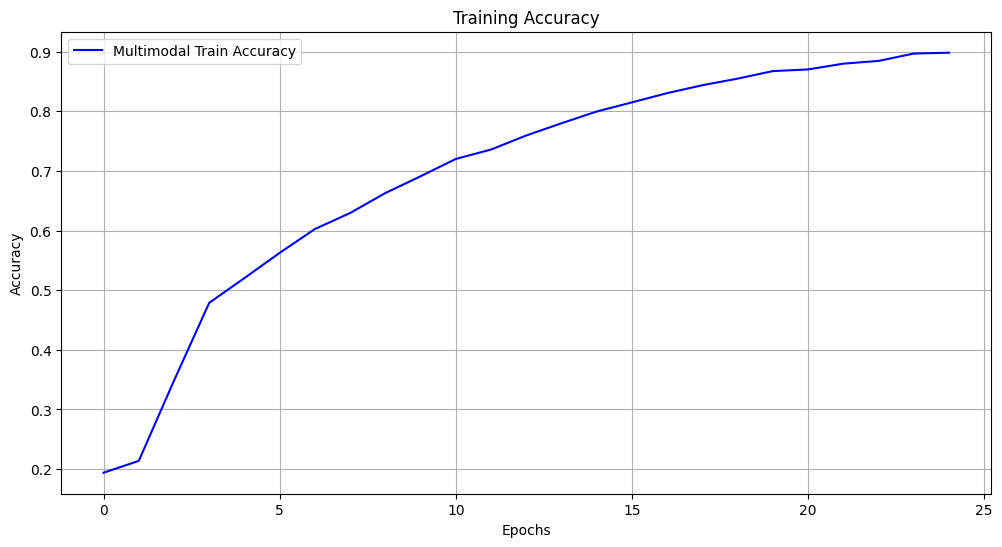

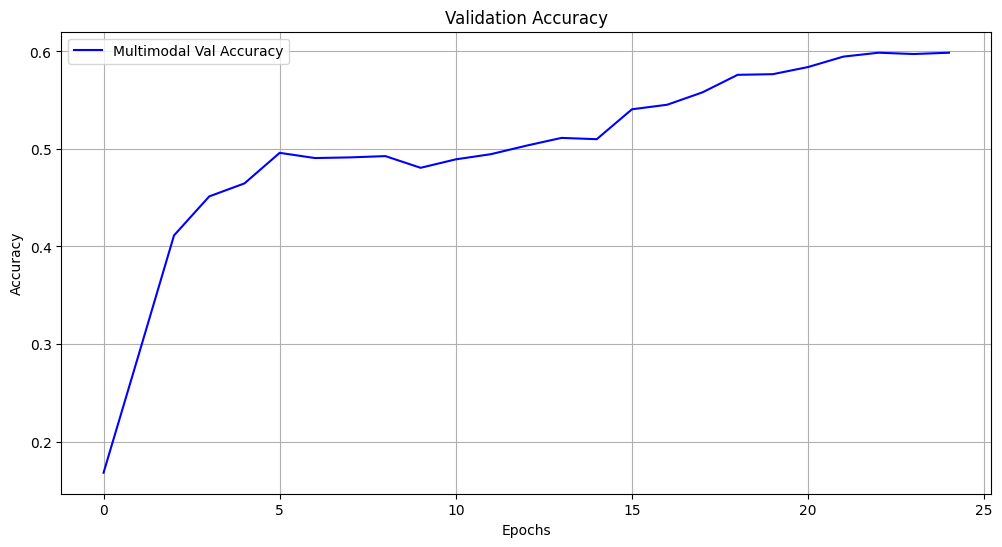

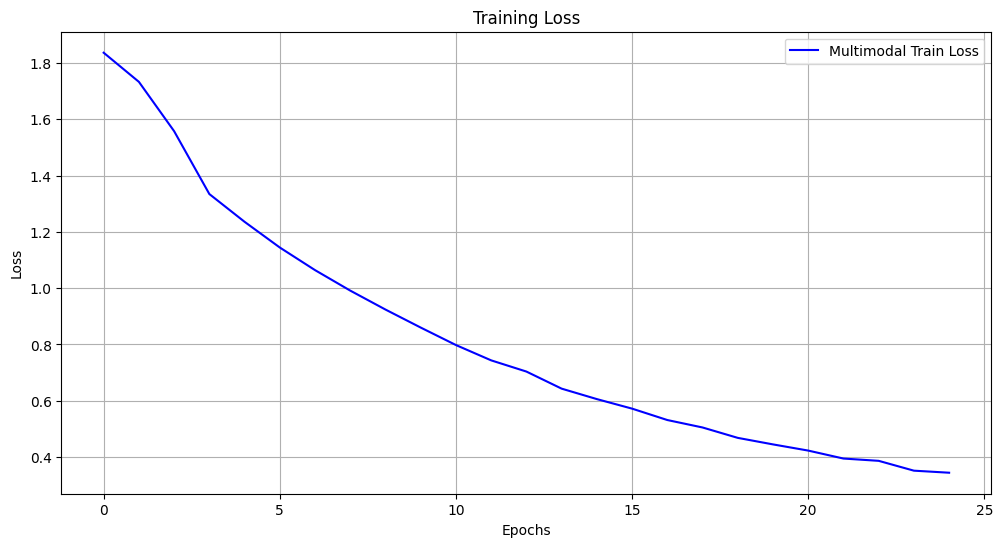

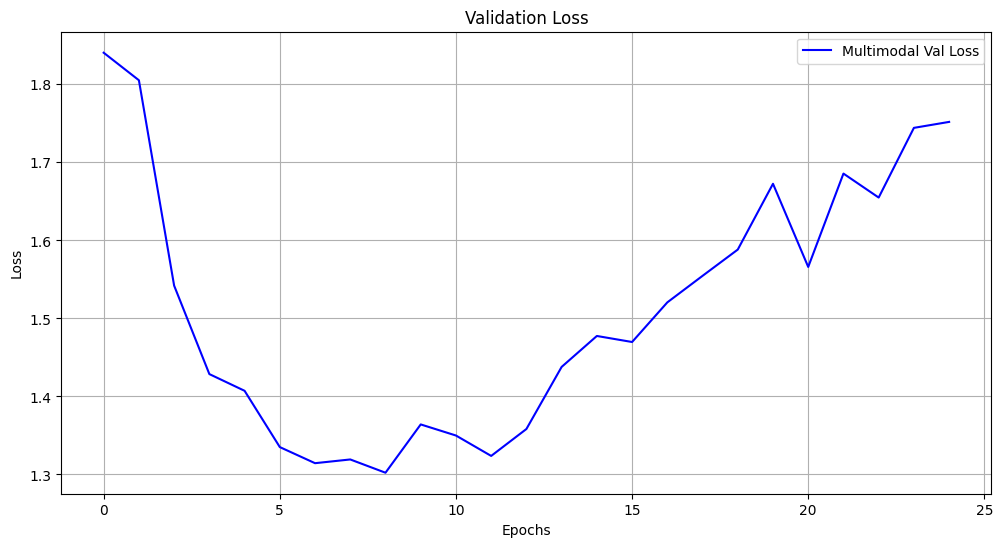

In [65]:
import matplotlib.pyplot as plt

# Training Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Multimodal Train Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_accuracy'], label='Multimodal Val Accuracy', color='blue')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Training Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Multimodal Train Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_loss'], label='Multimodal Val Loss', color='blue')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

In [67]:
# Select 5 random indices from the entire dataset
random_indices = random.sample(range(len(df)), 5)

# Prepare the images and corresponding labels for visualization
images_to_show = []
true_labels = []
predicted_binary_labels = []
predicted_multimodal_labels = []

In [68]:
# Process images and get predictions
for idx in random_indices:
    # Get the image path from the dataset
    img_path = df['image_path'][idx]
    img = load_img(img_path, target_size=(224, 224))  # Resize image to fit model input size
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 224, 224, 3)
    img_array = preprocess_input(img_array)  # Preprocessing for ResNet50

    # Preprocess the text using the tokenizer (convert text to sequence)
    text_sequence = tokenizer.texts_to_sequences([df['cleaned_text'][idx]])
    text_padded = pad_sequences(text_sequence, maxlen=100)  # Adjust `maxlen` based on your model's input length

    images_to_show.append(img)
    true_labels.append(df['majority_label_str'][idx])  # True labels from the dataset for multimodal model

    # Get multimodal model prediction (for multimodal classification)
    multimodal_prediction = multimodal_model.predict([img_array, text_padded])
    multimodal_predicted_label = np.argmax(multimodal_prediction, axis=1)  # Multi-class classification
    predicted_multimodal_labels.append(multimodal_predicted_label[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


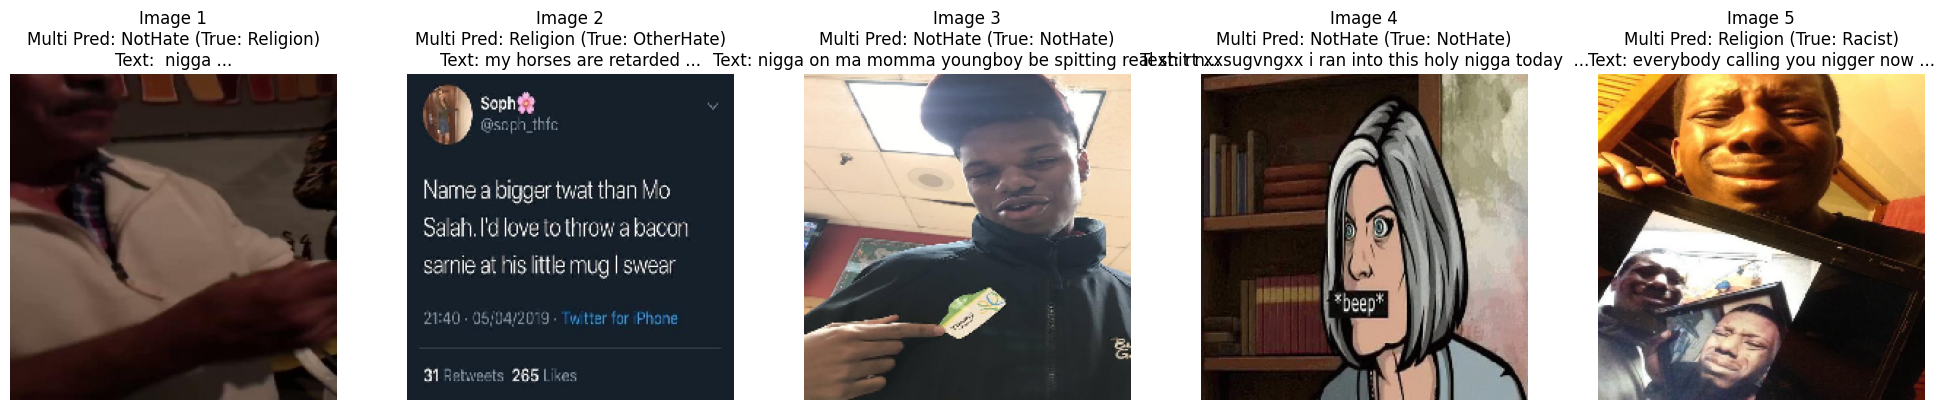

In [ ]:
# Create the figure for displaying images and predictions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Label mappings for multimodal model
multimodal_label_mapping = {
    0: "NotHate",
    1: "Racist",
    2: "Sexist",
    3: "Homophobe",
    4: "Religion",
    5: "OtherHate"
}

# Display images with their predictions from the multimodal model
for i, ax in enumerate(axes):
    ax.imshow(images_to_show[i])
    ax.axis('off')

    # Get the true label strings (from dataset)
    true_multimodal_label_str = multimodal_label_mapping[df['majority_label'][i]]  # Actual label for multimodal model
    text_data = df['cleaned_text'][i]  # Text data corresponding to the image

    # Get the predicted labels (from models)
    multimodal_predicted_label = int(predicted_multimodal_labels[i])  # Convert to integer scalar for multimodal model

    # Get predicted label strings
    multimodal_predicted_label_str = multimodal_label_mapping[multimodal_predicted_label]

    # Display the results on the image
    ax.set_title(f"Image {i+1}\nMulti Pred: {multimodal_predicted_label_str} (True: {true_multimodal_label_str})\n"
                 f"Text: {text_data[:50]}...")  # Show first 50 characters of the text for brevity

plt.tight_layout()
plt.show()